In [15]:
from PIL import Image, ImageDraw, ImageFilter
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from tensorflow.keras import optimizers
from tqdm import tqdm
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,6)


In [16]:
backgrounds_folder='./backgrounds'
signs_folder='./signs'
backgrounds=os.listdir(backgrounds_folder)
signs=os.listdir(signs_folder)
print(len(backgrounds), ' backgrounds')
print(len(signs), ' signs')

8  backgrounds
15  signs


### Generate data

In [17]:
canvas_size=(400,300)
sign_size_min=100
sign_size_max=150
samples=2000
test_samples=100

In [18]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

In [19]:
for i in tqdm(range(samples)):
    #pick random sign
    sign_index=random.randint(0,len(signs)-1)
    sign=Image.open(signs_folder+'/'+signs[sign_index])
    size=random.randint(sign_size_min,sign_size_max)
    sign=sign.resize((size,size))
    #pick random background
    background_index=random.randint(0,len(backgrounds)-1)
    background=Image.open(backgrounds_folder+'/'+backgrounds[background_index])
    background=background.resize(canvas_size)
    #mask
    mask_im = Image.new("L", sign.size, 0)
    draw = ImageDraw.Draw(mask_im)
    draw.ellipse((0, 0, sign.size[0], sign.size[1]), fill=255)
    mask_im_blur = mask_im.filter(ImageFilter.GaussianBlur(5))
    top_left_x=random.randint(0,background.size[0]-sign.size[0])
    top_left_y=random.randint(0,background.size[1]-sign.size[1])
    background.paste(sign, (top_left_x, top_left_y), mask_im_blur)
    label=[top_left_x, top_left_y,top_left_x+sign.size[0], top_left_y+sign.size[1]]
    if i <(samples-test_samples):
        x_train+=[np.array(background)]
        y_train+=[label]
    else:
        x_test+=[np.array(background)]
        y_test+=[label]

100%|██████████| 2000/2000 [00:44<00:00, 45.13it/s]


In [20]:
def plot(X,Y):
    plt.imshow(X)
    padding=0
    plt.scatter([Y[0],Y[2],Y[0],Y[2]],\
                [Y[1],Y[3],Y[3],Y[1]],c='red')
    ax = plt.gca()
    ax.add_patch(patches.Rectangle((Y[0],Y[1]),Y[2]-Y[0],Y[3]-Y[1],linewidth=2,edgecolor='r',facecolor='none'))
    return plt

In [21]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

## Preprocessing

#### Edge

In [22]:
edges_train=np.copy(x_train[:,:,:,0])
x_train_c=np.copy(x_train)

for i in range(samples-test_samples):
    x_train_c[i]=cv2.cvtColor(x_train[i], cv2.COLOR_RGB2BGR)
    edges_train[i]=cv2.Canny(x_train_c[i],100,250) #0 no edge 255 edge

edges_train=edges_train.reshape(samples-test_samples, canvas_size[1], canvas_size[0],1)

edges_test=np.copy(x_test[:,:,:,0])
x_test_c=np.copy(x_test)

for i in range(test_samples):
    x_test_c[i]=cv2.cvtColor(x_test[i], cv2.COLOR_RGB2BGR)
    edges_test[i]=cv2.Canny(x_test_c[i],100,250) #0 no edge 255 edge

edges_test=edges_test.reshape(test_samples, canvas_size[1], canvas_size[0],1)    

In [23]:
cv2.imshow('edges',edges_train[0])
cv2.imshow('org',x_train[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Bilateral Filter (only run if needed)

In [55]:
bil_train=np.copy(x_train)

for i in tqdm(range(samples-test_samples)):
    bil_train[i]=cv2.cvtColor(x_train[i], cv2.COLOR_RGB2BGR)
    bil_train[i]=cv2.bilateralFilter(bil_train[i], -1, 2, 15) #input, diameter(if neg. use space), color, space
    
bil_test=np.copy(x_test)

for i in tqdm(range(samples-test_samples)):
    bil_test[i]=cv2.cvtColor(x_test[i], cv2.COLOR_RGB2BGR)
    bil_test[i]=cv2.bilateralFilter(bil_test[i], -1, 2, 15)   
    
#cv2.imshow('org',cv2.cvtColor(x_train[0], cv2.COLOR_RGB2BGR))
#cv2.imshow('bil',bil_train[0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

100%|██████████| 1900/1900 [24:53<00:00,  1.27it/s]


#### Histograms

In [24]:
row_train=np.zeros((samples-test_samples, canvas_size[1], 3, 1))
for i in range(samples-test_samples):
    for j in range(canvas_size[1]):
        for c in range(3):
            row_train[i,j,c]=np.sum(x_train[i,j,:,c])
            
row_test=np.zeros((test_samples, canvas_size[1], 3, 1))
for i in range(test_samples):
    for j in range(canvas_size[1]):
        for c in range(3):
            row_train[i,j,c]=np.sum(x_test[i,j,:,c])


            
col_train=np.zeros((samples-test_samples, canvas_size[0], 3, 1))
for i in range(samples-test_samples):
    for j in range(canvas_size[0]):
        for c in range(3):
            col_train[i,j,c]=np.sum(x_train[i,:,j,c])
            
col_test=np.zeros((test_samples, canvas_size[0], 3, 1))
for i in range(test_samples):
    for j in range(canvas_size[0]):
        for c in range(3):
            col_test[i,j,c]=np.sum(x_test[i,:,j,c])
            
            
print(row_train.shape)

(1900, 300, 3, 1)


## Normalization

In [14]:
#x_train = x_train.reshape(x_train.shape[0], canvas_size[0], canvas_size[1],3)
#x_test = x_test.reshape(x_test.shape[0],  canvas_size[0], canvas_size[1],3)

#Normalization
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train.astype('float32')/max(canvas_size)
y_test = y_test.astype('float32')/max(canvas_size)

#edge detection
edges_train = edges_train.astype('float32')/255
edges_test = edges_test.astype('float32')/255

#bilateral
#bil_train = bil_train.astype('float32')/255
#bil_test = bil_test.astype('float32')/255

#histogram
row_train = row_train.astype('float32')/(canvas_size[0]*255)
row_test = row_test.astype('float32')/(canvas_size[0]*255)
col_train = col_train.astype('float32')/(canvas_size[1]*255)
col_test = col_test.astype('float32')/(canvas_size[1]*255)

NameError: name 'edges_train' is not defined

## Define and train model

### Edge

In [44]:
img_input = keras.Input(shape=(canvas_size[1], canvas_size[0], 3), name="image")
edges_input = keras.Input(shape=(canvas_size[1], canvas_size[0], 1), name="edges")

x = layers.MaxPooling2D(pool_size=(4,4))(img_input)
x = layers.Convolution2D(14, (3,3),activation='relu')(x)
x = layers.Convolution2D(14, (3,3),activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4,4))(x)
x = layers.Convolution2D(10, (3,3),activation='relu')(x)
x = layers.Convolution2D(10, (3,3),activation='relu')(x)
x_flat = layers.Flatten()(x)
e = layers.MaxPooling2D(pool_size=(4,4))(edges_input)
e = layers.Convolution2D(14, (3,3),activation='relu')(e)
e_flat = layers.Flatten()(e)

conc = layers.concatenate([x_flat, e_flat])
#den = layers.Dense(32, activation='relu')(conc)
pos_pred = layers.Dense(4, name="output")(conc)

model = keras.Model(inputs=[img_input, edges_input], outputs=[pos_pred])

In [45]:
model.compile(optimizer='adam',loss='mse')


In [46]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 300, 400, 3) 0                                            
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 75, 100, 3)   0           image[0][0]                      
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 73, 98, 14)   392         max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 71, 96, 14)   1778        conv2d_17[0][0]                  
____________________________________________________________________________________________

In [47]:
history=model.fit(
    {"image": x_train, "edges": edges_train},
    {"output": y_train},
    epochs=40,
)

Epoch 1/40
60/60 [==============================] - ETA: 0s - loss: 0.367 - ETA: 7s - loss: 82.92 - ETA: 10s - loss: 58.232 - ETA: 11s - loss: 43.741 - ETA: 11s - loss: 35.047 - ETA: 11s - loss: 29.242 - ETA: 11s - loss: 25.103 - ETA: 11s - loss: 21.994 - ETA: 11s - loss: 19.578 - ETA: 11s - loss: 17.644 - ETA: 11s - loss: 16.062 - ETA: 11s - loss: 14.744 - ETA: 11s - loss: 13.628 - ETA: 10s - loss: 12.672 - ETA: 10s - loss: 11.844 - ETA: 10s - loss: 11.122 - ETA: 10s - loss: 10.492 - ETA: 10s - loss: 9.923 - ETA: 9s - loss: 9.4131 - ETA: 9s - loss: 8.954 - ETA: 9s - loss: 8.539 - ETA: 9s - loss: 8.163 - ETA: 9s - loss: 7.820 - ETA: 8s - loss: 7.503 - ETA: 8s - loss: 7.212 - ETA: 8s - loss: 6.945 - ETA: 8s - loss: 6.697 - ETA: 7s - loss: 6.467 - ETA: 7s - loss: 6.252 - ETA: 7s - loss: 6.051 - ETA: 7s - loss: 5.864 - ETA: 6s - loss: 5.689 - ETA: 6s - loss: 5.523 - ETA: 6s - loss: 5.367 - ETA: 6s - loss: 5.221 - ETA: 5s - loss: 5.083 - ETA: 5s - loss: 4.952 - ETA: 5s - loss: 4.829 - ETA:

60/60 [==============================] - ETA: 0s - loss: 0.088 - ETA: 7s - loss: 0.084 - ETA: 9s - loss: 0.088 - ETA: 10s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 10s - loss: 0.09 - ETA: 9s - loss: 0.0927 - ETA: 9s - loss: 0.092 - ETA: 9s - loss: 0.093 - ETA: 9s - loss: 0.092 - ETA: 9s - loss: 0.092 - ETA: 9s - loss: 0.092 - ETA: 8s - loss: 0.091 - ETA: 8s - loss: 0.091 - ETA: 8s - loss: 0.091 - ETA: 8s - loss: 0.091 - ETA: 7s - loss: 0.091 - ETA: 7s - loss: 0.091 - ETA: 7s - loss: 0.091 - ETA: 7s - loss: 0.090 - ETA: 6s - loss: 0.091 - ETA: 6s - loss: 0.091 - ETA: 6s - loss: 0.091 - ETA: 6s - loss: 0.091 - ETA: 5s - loss: 0.091 - ETA: 5s - loss: 0.091 - ETA: 5s - loss: 0.090 - ETA: 5s - loss: 0.090 

60/60 [==============================] - ETA: 0s - loss: 0.034 - ETA: 7s - loss: 0.034 - ETA: 9s - loss: 0.033 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 9s - loss: 0.0370 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.036 - ETA: 9s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.036 - ETA: 8s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.036 - ETA: 6s - loss: 0.036 - ETA: 6s - loss: 0.036 - ETA: 6s - loss: 0.036 - ETA: 6s - loss: 0.036 - ETA: 5s - loss: 0.036 - ETA: 5s - loss: 0.036 - ETA: 5s - loss: 0.036 - ETA: 5s - loss: 0.036 - ETA: 4s - loss: 0.036 

60/60 [==============================] - ETA: 0s - loss: 0.028 - ETA: 7s - loss: 0.028 - ETA: 9s - loss: 0.030 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.02 - ETA: 10s - loss: 0.02 - ETA: 10s - loss: 0.02 - ETA: 9s - loss: 0.0295 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.029 - ETA: 9s - loss: 0.029 - ETA: 8s - loss: 0.029 - ETA: 8s - loss: 0.029 - ETA: 8s - loss: 0.029 - ETA: 8s - loss: 0.029 - ETA: 7s - loss: 0.029 - ETA: 7s - loss: 0.029 - ETA: 7s - loss: 0.029 - ETA: 7s - loss: 0.029 - ETA: 7s - loss: 0.029 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.029 - ETA: 6s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 4s - loss: 0.029 

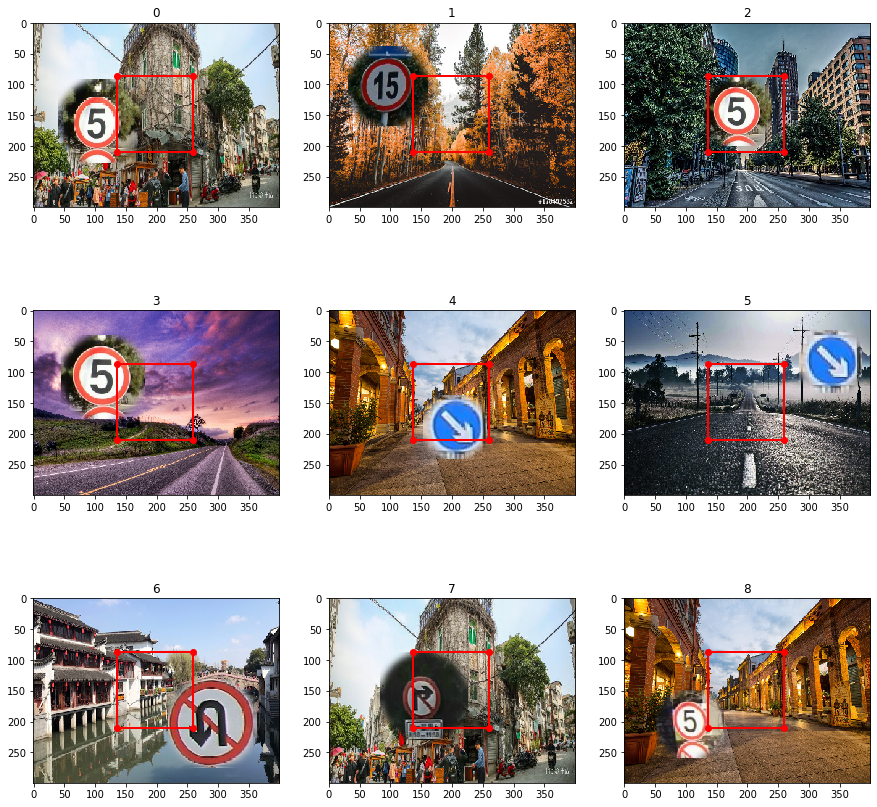

In [48]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax= plt.subplot(3,3,i+1)
    k = random.randint(0,len(x_test))-1
    x=x_test[k]
    e=edges_test[k]
    y=model.predict({"image": np.array([x]), "edges": np.array([e])})[0]
    im=plot(x,y*max(canvas_size))
    plt.title(i)

### Histogram

In [ ]:
img_input = keras.Input(shape=(canvas_size[1], canvas_size[0], 3), name="image")
row_input = keras.Input(shape=(canvas_size[1], 3, 1), name="row")
col_input = keras.Input(shape=(canvas_size[0], 3, 1), name="col")

x = layers.MaxPooling2D(pool_size=(4,4))(img_input)
x = layers.Convolution2D(14, (3,3),activation='relu')(x)
x = layers.Convolution2D(14, (3,3),activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(4,4))(x)
x = layers.Convolution2D(10, (3,3),activation='relu')(x)
x = layers.Convolution2D(10, (3,3),activation='relu')(x)
x_flat = layers.Flatten()(x)
r = layers.Dense(300)(row_input)
r_flat = layers.Flatten()(r)
c = layers.Dense(400)(col_input)
c_flat = layers.Flatten()(c)

conc = layers.concatenate([x_flat, r_flat, c_flat])
den = layers.Dense(32, activation='relu')(conc)
pos_pred = layers.Dense(4, name="output")(den)

model = keras.Model(inputs=[img_input, row_input, col_input], outputs=[pos_pred])

In [ ]:
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.summary()

In [ ]:
history=model.fit(
    {"image": x_train, "row": row_train, "col": col_train},
    {"output": y_train},
    epochs=40, 
)

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax= plt.subplot(3,3,i+1)
    k = random.randint(0,len(x_test))-1
    x=x_test[k]
    r=row_test[k]
    c=col_test[k]
    y=model.predict({"image": np.array([x]), "row": np.array([r]), "col": np.array([c])})[0]
    im=plot(x,y*max(canvas_size))
    plt.title(i)